In [1]:
from utils import *

In [2]:
# 1. Load Data
df_b, df_climatic = load_data()
df_climatic_wide = transform_climatic_data(df_climatic)
df_b = transform_barley_data(df_b)

# 2. Prepare Data
df_climatic_yearly = transform_climatic_yearly(df_climatic_wide)
df_climatic_historical = df_climatic_yearly[df_climatic_yearly['scenario'] == 'historical'].copy().drop(columns=['scenario'])

# 3. Proceed with your existing merge using the historical subset
df_combined = merge_climatic_yearly(df_climatic_historical, df_b)


In [3]:
departments = []
models_rf_dict = {}

for department_name in df_combined['department'].unique():
    departments.append(department_name)
    # Train and store in the dictionary
    models_rf_dict[department_name] = train_rf(df_combined, department_name)

In [4]:
departments = []
models_xgb = []

for department_name in df_combined['department'].unique():
    departments.append(department_name)
    models_xgb.append(train_xgb(df_combined, department_name))

In [5]:
df_climatic_pessimistic = df_climatic_yearly[df_climatic_yearly['scenario'] == 'ssp5_8_5'].copy().drop(columns=['scenario'])
df_climatic_medium = df_climatic_yearly[df_climatic_yearly['scenario'] == 'ssp2_4_5'].copy().drop(columns=['scenario'])
df_climatic_optimistic = df_climatic_yearly[df_climatic_yearly['scenario'] == 'ssp1_2_6'].copy().drop(columns=['scenario'])

In [6]:
# 3. Call the function using your original dictionary
df_preds_optimistic = predict_scenario_yields_rf(models_rf_dict, df_climatic_optimistic)
df_preds_medium = predict_scenario_yields_rf(models_rf_dict, df_climatic_medium)
df_preds_pessimistic = predict_scenario_yields_rf(models_rf_dict, df_climatic_pessimistic)

In [7]:
# Combine scenarios
my_weights = {'opt': 0.25, 'med': 0.50, 'pess': 0.25}
df_master_projections = combine_scenarios_weighted(
    df_preds_optimistic, 
    df_preds_medium, 
    df_preds_pessimistic, 
    weights=my_weights
)

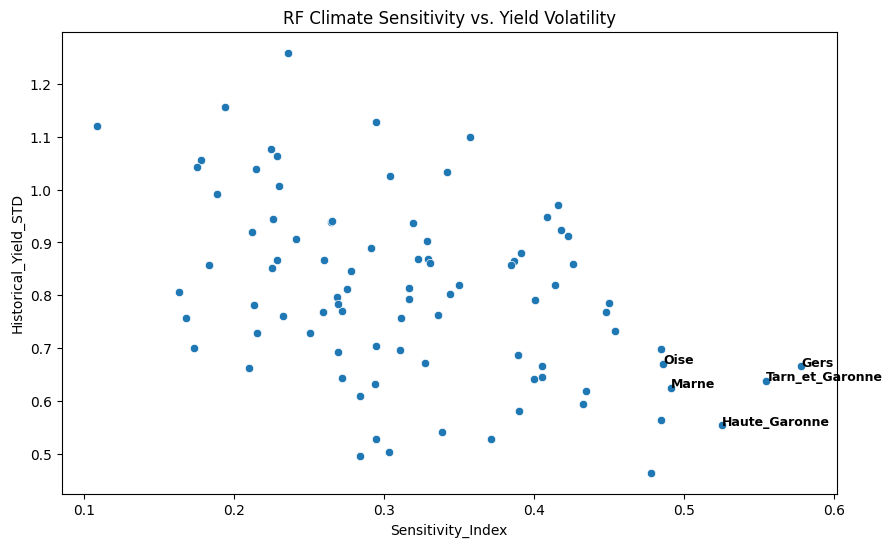

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Define feature list (ensuring it matches what the RF models were trained on)
exclude = ['yield', 'production', 'area', 'department']
features = [col for col in df_combined.columns if col not in exclude]

def analyze_regional_importance_rf(models_dict, features_list):
    importance_data = []
    
    for dept, model in models_dict.items():
        # Scikit-Learn RF stores importances in an array aligned with feature_names_in_
        importances = model.feature_importances_
        
        # Create a dictionary mapping feature names to their importance values
        dept_scores = dict(zip(features_list, importances))
        dept_scores['department'] = dept
        importance_data.append(dept_scores)
        
    return pd.DataFrame(importance_data).set_index('department')

# Use your existing models_rf_dict
df_importance = analyze_regional_importance_rf(models_rf_dict, features)

# 2. Normalize the Importance Matrix (Min-Max scaling)
# Adding a tiny epsilon to the denominator to prevent division by zero
df_norm = (df_importance - df_importance.min()) / (df_importance.max() - df_importance.min() + 1e-9)

# 3. Define "Risk" weightings
risk_weights = {
    'heat_stress_days': 0.20,
    'peak_heat_intensity': 0.20,
    'spring_dry_days': 0.15,
    'temp_anomaly': 0.15,
    'precip_anomaly': 0.15,
    'winter_cold_days': 0.15
}

# 4. Calculate the Climate Sensitivity Index (CSI)
# We filter risk_weights keys to ensure we only multiply columns that exist in df_norm
valid_keys = [k for k in risk_weights.keys() if k in df_norm.columns]
df_norm['CSI'] = df_norm[valid_keys].mul(pd.Series(risk_weights)).sum(axis=1)

# 5. Rank and Summarize
rankings = df_norm['CSI'].sort_values(ascending=False)

analysis_summary = pd.DataFrame({
    'Sensitivity_Index': df_norm['CSI'],
    'Historical_Yield_STD': df_combined.groupby('department')['yield'].std()
})

# 6. Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=analysis_summary, x='Sensitivity_Index', y='Historical_Yield_STD')

# Label the Top 5 most sensitive
for dept in rankings.head(5).index:
    if dept in analysis_summary.index:
        plt.text(analysis_summary.loc[dept, 'Sensitivity_Index'], 
                 analysis_summary.loc[dept, 'Historical_Yield_STD'], 
                 dept, fontsize=9, fontweight='bold')

plt.title('RF Climate Sensitivity vs. Yield Volatility')
plt.show()

In [13]:
# 1. Map Sensitivity Index to the Master Dataframe
# We use the CSI calculated from your RF Importance analysis
sensitivity_map = df_norm['CSI'].to_dict()

df_master_projections['sensitivity'] = df_master_projections['department'].map(sensitivity_map)

# 2. Create the Risk-Adjusted Yield metric
# Logic: We divide yield by (1 + sensitivity) to avoid division by zero 
# and to ensure that higher sensitivity lowers the "Adjusted" value.
df_master_projections['risk_adjusted_yield'] = (
    df_master_projections['yield'] / (1 + df_master_projections['sensitivity'])
)

In [16]:
# Exporting the master projections with sensitivity and risk-adjusted metrics
df_master_projections.to_csv('BCG_pred.csv', index=False, sep=';', encoding='utf-8-sig')

print("Export successful: BCG_pred.csv")

Export successful: BCG_pred.csv
